In [14]:
import numpy as np
import multiprocessing as mp
from multiprocessing import Pool, cpu_count, Value
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.cluster import KMeans
import os.path
import cv2
import matplotlib.pyplot as plt
from ctypes import *
import sys
import threading
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from read_image import read_images

In [15]:
def readLabels(label_dir, label_name):
    with open(os.path.join(label_dir, label_name), "r") as f:
        content = f.read()
    
    label = content.split(",")
    label = map(lambda x: int(x), label)
    return np.array(list(label))

def run(fnc, images, data):
    images.append(None)
    with Pool(cpu_count()) as pool:
        images[0] = pool.map(fnc, data)
        

In [16]:
SO_DIRPATH = "../libs/"
TRAIN_IMAGES_DIR = "../../mnist/images/train_images" 
TEST_IMAGES_DIR = "../../mnist/images/test_images"
TRAIN_LABELS_DIR = "../../mnist/labels/train_labels"
TEST_LABELS_DIR =  "../../mnist/labels/test_labels"
IMAGE_NAME = "number{}.png"
LABELS_NAME = "labels.txt"
LOOP_LABELS_NAME = "loops.txt"
N_TRAIN = 60000

In [64]:
number_label_train = readLabels(TRAIN_LABELS_DIR, LABELS_NAME)[:N_TRAIN]
loop_label_train = readLabels(TRAIN_LABELS_DIR, LOOP_LABELS_NAME)[:N_TRAIN]
number_label_test = readLabels(TEST_LABELS_DIR, LABELS_NAME)[:N_TRAIN]
loop_label_train = readLabels(TEST_LABELS_DIR, LOOP_LABELS_NAME)[:N_TRAIN]

In [18]:
images = []
data = [os.path.join(TRAIN_IMAGES_DIR, IMAGE_NAME.format(i + 1)) for i in range(N_TRAIN)]
t = threading.Thread(target = run, args=(read_images, images, data,  ))
t.start()
while t.is_alive():
        sys.stdout.write('\r' + "n_finished={}".format(n_finished.value))
        sys.stdout.flush()

n_finished=0

In [ ]:
X_train = np.array(images[0])
y_train = np.array(number_label_train)

In [ ]:
images = []
data = [os.path.join(TEST_IMAGES_DIR, IMAGE_NAME.format(i + 1)) for i in range(N_TRAIN)]
t = threading.Thread(target = run, args=(read_images, images, data,  ))
t.start()
while t.is_alive():
        sys.stdout.write('\r' + "n_finished={}".format(n_finished.value))
        sys.stdout.flush()

n_finished=0

In [33]:
X_test = np.array(images[0])
y_test = np.array(number_label_test)

array([5])

# Preprocess

In [35]:
# append label into y
new_y = []
for i in range(N_TRAIN):
    new_y.append((y_train[i], loop_label_train[i]))

In [36]:
X_train = np.array(X_train).reshape(60000, 28, 28, 1)
new_y = np.array(new_y)

In [38]:
datagen = ImageDataGenerator(
    rotation_range=90, 
    width_shift_range=1, 
    height_shift_range=1,
    zoom_range=0.25
)

it = datagen.flow(X_train, new_y)

In [54]:
X_augmented_with_loop = []
y_augmented = []
n_batch = 3 * N_TRAIN // 32
batch = next(it, None)
for i in range(n_batch):
    imgs, labels = batch
    for i in range(len(imgs)):
      X_augmented_with_loop.append(np.append(imgs[i], labels[i][1]))
      y_augmented.append(labels[i][0])
    batch = next(it, None)

In [55]:
X_train_final = X_augmented_with_loop
y_train = y_augmented

# Model Training

## 1. KNN Classifier

In [56]:
knn_clf = KNeighborsClassifier(n_neighbors=4, weights="distance", n_jobs=-1)
knn_clf.fit(X_train_final, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=4, weights='distance')

## 2. XGB

# Optimization

In [ ]:
param_grid = {
    "n_neighbors": [4, 5, 6, 7, 8, 40, 400], 
    "weights": ["uniform", "distance"], 
}

In [ ]:
cv = EvolutionaryAlgorithmSearchCV(estimator=KNeighborsClassifier(),
                                   params=param_grid,
                                   scoring="accuracy",
                                   cv=StratifiedKFold(n_splits=4),
                                   verbose=1,
                                   population_size=50,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=5,
                                   n_jobs=4)

In [ ]:
#cv.fit(X_train_final, y_train)

# Evaluation

In [57]:
cross_val_score(knn_clf, X_train_final, y_train, cv=3, scoring="accuracy")

array([0.93653333, 0.93741667, 0.93816667])

In [58]:
y_train_predict = cross_val_predict(knn_clf, X_train_final, y_train, cv=3)

In [59]:
conf_mx = confusion_matrix(y_train, y_train_predict)

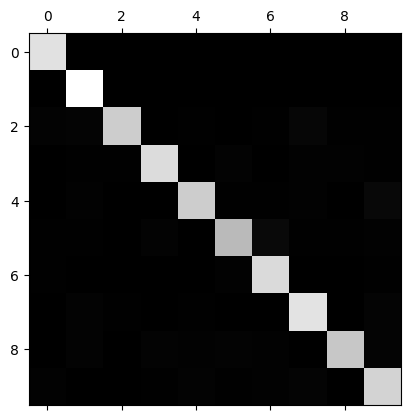

In [60]:
plt.matshow(conf_mx, cmap="gray")

In [61]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

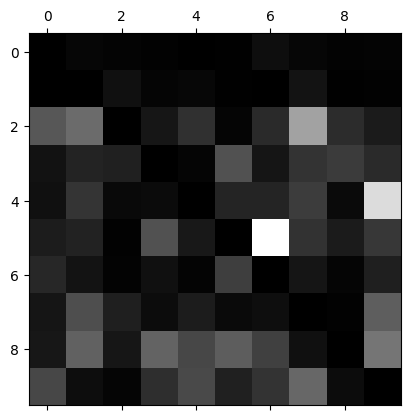

In [62]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

In [63]:
knn_clf.score(X_test_final, y_test)

NameError: name 'X_test_final' is not defined

In [ ]:
y_predict = knn_clf.predict(X_test_final)

In [ ]:
conf_mx = confusion_matrix(y_test, y_predict)
plt.matshow(conf_mx, cmap="gray")

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)